In [96]:
%load_ext autoreload
%autoreload 2
%env MIRA_REST_URL=http://34.230.33.149:8771


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: MIRA_REST_URL=http://34.230.33.149:8771


In [97]:
from mira.sources import biomodels
from mira.metamodel.comparison import *
from mira.dkg.web_client import is_ontological_child_web
from mira.examples.sir import * 

In [98]:
rc = get_dkg_refinement_closure()

In [99]:
NON_COVID_EPI_MODELS_SET= {
    "MODEL1808280006",  # SIRWS model with immune boosting and cross-immunity between two pathogens
}


In [109]:
tm_list = [] 
tm_list.append(sir_parameterized)

for bio_model_id in NON_COVID_EPI_MODELS_SET:
    bio_model = biomodels.get_template_model(bio_model_id)
    tm_list.append(bio_model)




In [117]:
tm_comparison = TemplateModelComparison(tm_list,refinement_func=rc.is_ontological_child)

Comparing model templates: 1711it [00:00, 430552.80it/s]
Comparing model concepts: 171it [00:00, 237334.87it/s]


AttributeError: 'TemplateModelComparison' object has no attribute 'get_similarity_score'

In [116]:
tm_comparison.model_comparison.get_similarity_score(0,1)

0.0

In [104]:
test = tm_comparison.model_comparison

In [92]:
tmd = TemplateModelDelta(tm_comparison.template_models[0],tm_comparison.template_models[1],rc.is_ontological_child)



In [112]:
image = TemplateModelDelta.for_jupyter(tm_comparison.template_models[0],tm_comparison.template_models[1],rc.is_ontological_child)

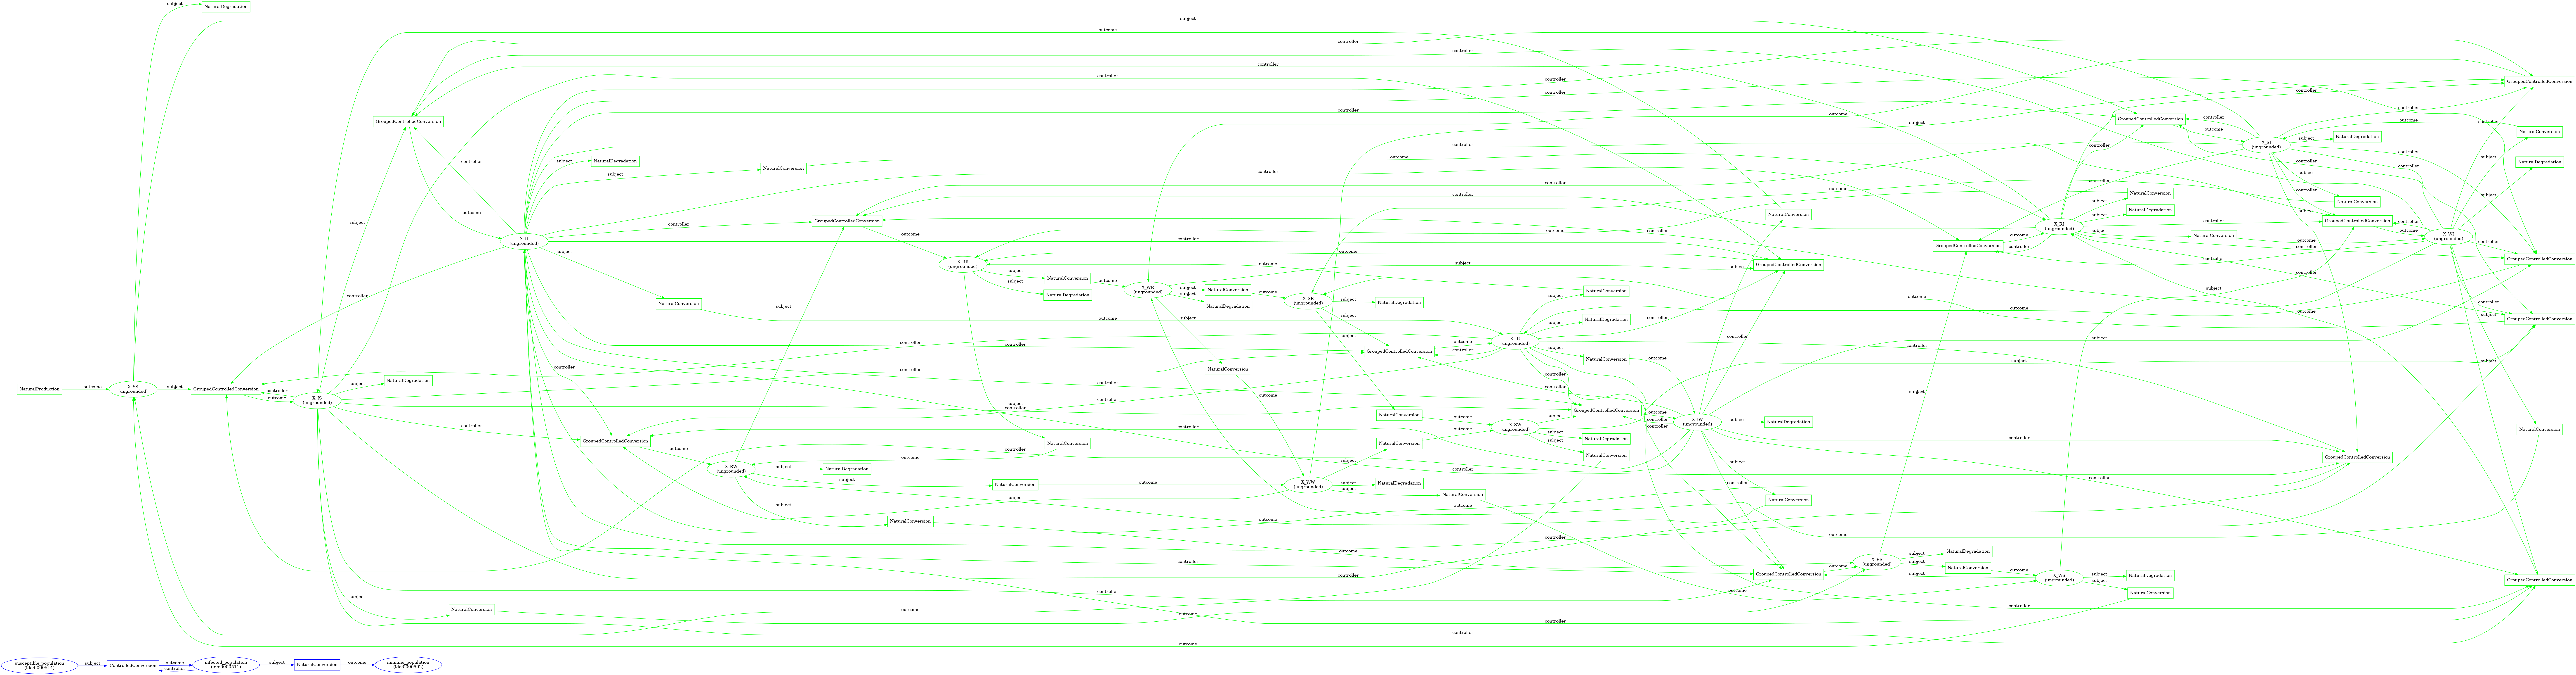

In [113]:
image